# Assignment 3 - Decision Trees
## CART Implementation - Building a Decision Tree Classifier:

I build a `class` for `decision tree classifier`. This class take the following attributes:

1. **Maximum purity per internal node** : This value is a limit to stop further splitting of a node that has reached the specified purity value when the initial decision tree is being built. 
2. **Maximum tree depth**: is a limit to stop further splitting of nodes when the specified tree depth has been reached during the building of the initial decision tree.
3. **Minimum number of records per internal node**: This prevents further splitting of a node that has reached the specified minimal size when the initial decision tree is being built.
4. **Max categories** : is a limit for the number of unique values that a categorical attribute can have. When exceed, decision tree won't be built and error message will be printed.

The three first attributes are common ***pre-pruning procedures***. Pruning should reduce the size of a learning tree without reducing predictive accuracy as measured by a cross-validation set. 

After making an instance of decision tree classifier class, I use cross validation method to initiate training the classifier for *k times*, testing them and log accuracy. Cross validation is used to pick the best class attributes that could give the best accuracy on train and test datasets. 

This class can take a dataset that contain both *numeric and categorical attributes* and build suitable decision trees for *categorical labels*. 


In [1]:
# required libraries
from collections import defaultdict
import pandas as pd 
import numpy as np
from typing import NamedTuple, Any

In [2]:
class Classification_And_Regression_Tree ():
    def __init__(self,  Maximum_purity_per_internal_node, Maximum_tree_depth,
                 Minimum_number_of_records_per_internal_node, max_categories, verbose = True):
        self.tree = defaultdict(list)
        self.max_purity = Maximum_purity_per_internal_node
        self.max_depth = Maximum_tree_depth
        self.min_records_num = Minimum_number_of_records_per_internal_node
        self.max_categories = max_categories
        self.verbose = verbose
        
    def Gini_Index(self, feature_count, unique_labels):
        ''' 
        calculating gini index for a particular feature
        '''
        i = 0
        if (feature_count['Total'] == 0).any():
            # to avoid error 
            feature_count.loc[ feature_count['Total'] == 0, 'Total'] = 1

        # calculate gini index for each unique label
        for unique_outcome in unique_labels:
            if i == 0:
                feature_count['GI_feature'] = feature_count.apply(lambda x: 1- pow(x[unique_outcome] / x['Total'],2), axis=1)
                i += 1
            else:
                feature_count['GI_feature'] = feature_count.apply(lambda x: x['GI_feature']- pow(x[unique_outcome] / x['Total'],2), axis=1)

        feature_count['GI_sub_final'] = feature_count.apply(lambda x: x['GI_feature'] * x['Total'], axis=1)
        feature_count_final = sum(feature_count['GI_sub_final'])/sum(feature_count['Total'])
        return feature_count, feature_count_final
    
    def features_collector(self, data, features):
        ''' 
        detect numeric columns and transfer them to features 
        '''
        feature_copy = features.copy()
        for feature in feature_copy:
            if feature in data.select_dtypes("number").columns:
                features.remove(feature)
                if data[feature].diff().dropna().eq(1).all():
                      continue
                threshold_options = list(set(data.sort_values(by = feature)[feature]))
                threshold_options = [[feature, (threshold_options[i]+threshold_options[i+1])/2] for i in range(len(threshold_options)-1) ]

                features += threshold_options
        return features
                
    def best_split(self, data, features, label):
        '''
        collect gini index for all features, sort them and select the feature with the lowest index
        '''
        Gini_Index_feature = {}
        unique_labels = data[label].unique().tolist()
        for feature in features:
            if not isinstance(feature, str):
                '''numeric feature '''
                threshold = feature[1]
                feature = feature[0]
                larger_than_threshold = data[data[feature] > threshold][label].value_counts().to_frame().reset_index()
                lower_than_threshold = data[data[feature] <= threshold][label].value_counts().to_frame().reset_index()
                larger_than_threshold.rename(columns = {label:f'larger_than_{threshold}'}, inplace = True)
                lower_than_threshold.rename(columns = {label:f'lower_or_equal_to_{threshold}'}, inplace = True)
                lower_than_threshold = lower_than_threshold.pivot_table(columns= ['index'])
                larger_than_threshold = larger_than_threshold.pivot_table(columns= ['index'])
                feature_count = pd.concat([lower_than_threshold, larger_than_threshold]).fillna(0)
                feature_count['Total'] = feature_count[unique_labels].sum(axis = 1)
                feature_count, GI_index_final = self.Gini_Index(feature_count, unique_labels)
                Gini_Index_feature[(feature, threshold)] = [GI_index_final, feature_count]
            else: 
                '''category feature '''
                feature_count = data[[feature, label]].value_counts().to_frame().reset_index()
                feature_count = feature_count.pivot_table(index=[feature],
                                                          columns=[label],
                                                          values= 0).fillna(0)
                feature_count['Total'] = feature_count[unique_labels].sum(axis = 1, skipna = True)
                if (feature_count['Total']<2).all():
                    continue
                feature_count, GI_index_final = self.Gini_Index(feature_count, unique_labels)
                Gini_Index_feature[feature] = [GI_index_final, feature_count]
            
        node_lowest_gini_index = sorted(Gini_Index_feature, key=lambda k: Gini_Index_feature[k][0])[0]
        feature_count_lowest_gini_index = Gini_Index_feature[node_lowest_gini_index][1]
        lowest_gini_index = Gini_Index_feature[node_lowest_gini_index][0]
        return lowest_gini_index, node_lowest_gini_index, feature_count_lowest_gini_index
        
    def split_data(self, data, splitting_node, isnumeric_true):
        '''use splitting node to split data'''
        datasets = {}
        if isnumeric_true: 
            datasets[f'larger_than_{splitting_node[1]}'] = data[data[splitting_node[0]] > splitting_node[1]]
            datasets[f'lower_or_equal_to_{splitting_node[1]}'] = data[data[splitting_node[0]] <= splitting_node[1]]
        else:
            for feature in data[splitting_node].unique().tolist():                                                    
                datasets[feature] = data[data[splitting_node] == feature]
        return datasets
    
    def train(self, data, features, labels_column_title, depth_counter = 0, attribute_value =None, feature_count_gini = 100, previous_attribtue =None):
        ''' 
        use data to build and train a decision tree
        '''
        unique_labels = data[labels_column_title].unique().tolist()
        most_common_label = data[labels_column_title].value_counts().index[0], data[labels_column_title].value_counts()[0]
        if len(unique_labels) <= 1: 
            '''If the data all have the same label'''
            return Leaf(*most_common_label)
        
 
        if len(features) == 0:
            '''In case list of attributes is empty, create a leaf node that predicts the most 
            common label then stop.'''
            return Leaf(*most_common_label)  
        
        if self.max_depth <= depth_counter:

            '''In case depth of tree has exceed the acceptable threshold, create a leaf node that predicts 
            the most common label then stop.'''
            return Leaf(*most_common_label)
        
        if not isinstance(feature_count_gini, int):
            attribute_value_X = attribute_value
            if not isinstance(attribute_value_X, str):
                attribute_value_X = attribute_value[0]
            actual_gini_index = feature_count_gini.loc[attribute_value_X, 'GI_feature']
            if  actual_gini_index < self.max_purity:
                '''  in case splitting will not improve purity (minimum 0.03) and the purity has
                   reached an acceptable threshold, do not split further and create a leaf node '''  
                return Leaf(*most_common_label)

        if depth_counter == 0:
            '''
            in case number for a column's unique values exceed an acceptable threshold, send a error message
            '''
            types = data.dtypes
            if len([True for feature in features if isinstance(feature, list)]) ==0:
                features = self.features_collector(data, features)
                check_columns = types[types == "object"].index
                for column in check_columns:
                    var_length = len(data[column].value_counts())
                    if var_length > self.max_categories:
                        raise ValueError('The ' + column + ' attribute has '+ str(var_length)
                                         + ' unique values, which is more than the accepted threshold: ' 
                                         +  str(self.max_categories))
            depth_counter += 1
        else:
            if not previous_attribtue == attribute_value:
                depth_counter += 1
        
        if len(data) < self.min_records_num:
            '''In case the number of records went below an acceptable minimum number of records per internal node, 
            create a leaf node that predicts the most common label then stop.'''
            return Leaf(*most_common_label)

        previous_attribtue = attribute_value
        gini_index, next_spliting_node, feature_count_gini = self.best_split(data, features, labels_column_title)


        #split data and returned new splitted dataset 
        if not isinstance(next_spliting_node, str):
            features = [feature for feature in features if not next_spliting_node[0] in feature]
            splitted_dic = self.split_data(data, list(next_spliting_node), True)
        else:
            features.remove(next_spliting_node)
            splitted_dic = self.split_data(data, next_spliting_node, False)
    
        
        # create a subtrees with recursion
        subtrees = {attribute_value : self.train(subset, features,
                                                labels_column_title, depth_counter,
                                                 attribute_value, feature_count_gini, previous_attribtue)
                    for attribute_value, subset in splitted_dic.items()}
        
        return Internal_Split_Node(next_spliting_node, subtrees, 
                                   samples = len(data),
                                   label_distribution = data[labels_column_title].value_counts().to_dict(),
                                   default_value = most_common_label)

        
    def classify(self, tree, data_row):
        """classify data row using given decision tree"""
        if isinstance(tree, Leaf):
            # check whether tree consists of only a leaf node, then return leaf's value
            return tree.label


        if not isinstance(tree.attribute, str):
            # numeric splitting attribute
            if data_row[tree.attribute[0]] > tree.attribute[1]:
                subtree_key = f'larger_than_{tree.attribute[1]}'
            else:
                subtree_key =  f'lower_or_equal_to_{tree.attribute[1]}'

        else:
            subtree_key = data_row[tree.attribute]
            

        if subtree_key not in tree.subtrees.keys():   # If no subtree for key,
            return tree.default_value[0]          # return the default value.
        subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
        return self.classify(subtree, data_row)
    
    def predict(self, tree, data_slice):
        # make a prediction for a dataset by calling classify method for each row
        return data_slice.apply(lambda x: self.classify(tree, x), axis=1)
    
    def cross_validation(self, data, features_input, labels_column_title, cv = 5):
        '''split the data into cv number, make training/test data, use them to train and test a decision tree
        and record the accuracy for each fold. Afterwords, train a decision tree on the whole dataset and
        return a trained decision tree, a list of all folds accuracy, an average accuracy'''
        
        starting_index = 0
        ending_index = round(data.shape[0]/cv)
        counter = 0  #to initiate the counter used to calculate tree depth 
        cv_accuracy = []
        
        for i in range(cv):
            # slice the train data and train a decision tree
            features = features_input.copy()
            train_data = pd.concat([data[:starting_index],data[ending_index:]])
            DecisionTree = self.train(train_data, features, labels_column_title, counter)
            # slice the test data, split into x and y, use x for prediction then calculate accuracy 
            test_data = data[starting_index:ending_index]
            X_test_data = test_data.drop([labels_column_title], axis=1)
            y_test_data = test_data[labels_column_title]
            predicted_labels = self. predict(DecisionTree, X_test_data)
            accuracy = self.accuracy(predicted_labels, y_test_data)
            confusion_matrix = self.confusion_matrix(predicted_labels, y_test_data)
            if self.verbose:
                print(f'Confusion matrix for fold number {i+1} is as follow:\n {confusion_matrix}')
                print()
            cv_accuracy.append(accuracy)
            starting_index += round(data.shape[0]/cv)
            ending_index += round(data.shape[0]/cv)

        avg_accuracy = sum(cv_accuracy) / len(cv_accuracy) 
        # train on full data
        DecisionTree = self.train(data, features_input, labels_column_title, counter)    
        return DecisionTree, avg_accuracy, cv_accuracy
    
    def accuracy(self, predicted_labels, y_test_data):
        '''calculate accuracy by comparing between actual and predicted labels'''
        comparison_column = np.where(predicted_labels == y_test_data, True, False)
        return np.count_nonzero(comparison_column == True)/len (comparison_column)
    
    def confusion_matrix (self, predicted_labels, y_test_data):
        '''calculate a confusion matrix for multilabel classification'''
        df = pd.DataFrame({'predicted': predicted_labels, 'actual': y_test_data}, columns=['predicted', 'actual'])
        return (df.groupby(['predicted', 'actual']).size().unstack(fill_value=0))

I build also a seperate class for `Leaf` node and `Internal_Split` node in order to use them when constructing decision tree nodes. 

In [3]:
class Leaf(NamedTuple):
    ''' 
    an information container for each leaf.
    '''
    label: Any
    Samples : int 
    

class Internal_Split_Node(NamedTuple):
    ''' 
    an information container for each internal node.
    '''
    attribute: str
    subtrees: dict
    samples : int
    label_distribution : list
    default_value: Any = None
        

## Weather Dataset
### Dataset ingestion and Data Wrangling::
Using read_csv method of pandas package, I imported weather data's csv file. This method trasnfer the data into tabuluar dataframe. 

In [4]:
# required libraries for data handling 
import matplotlib.pyplot as plt

In [5]:
#using the day column as index for the dataframe. 
weather_data = pd.read_csv('weather-data.csv', index_col= 0) 
weather_data.head(5)

,Outlook,Temperature,Humidity,Wind,Decision
Day,,,,,
1,Sunny,Hot,High,Weak,No
2,Sunny,Hot,High,Strong,No
3,Overcast,Hot,High,Weak,Yes
4,Rainfall,Mild,High,Weak,Yes
5,Rainfall,Cool,Normal,Weak,Yes


Dataset contains only 14 lines and all columns include categorical attributes. Each columns has 2-3 unique values. 

In [6]:
weather_data.describe(include = 'object')

,Outlook,Temperature,Humidity,Wind,Decision
count,14,14,14,14,14
unique,3,3,2,2,2
top,Sunny,Mild,High,Weak,Yes
freq,5,6,7,8,9


We note that there is an imbalance in data as 9 out of 14 data entry has 'yes' as a decision which will have an effect on the classifier performance on real data and introduce biase. Wind and humidity have 2 unique values whereas outlook and temperature have 3 unique values. 

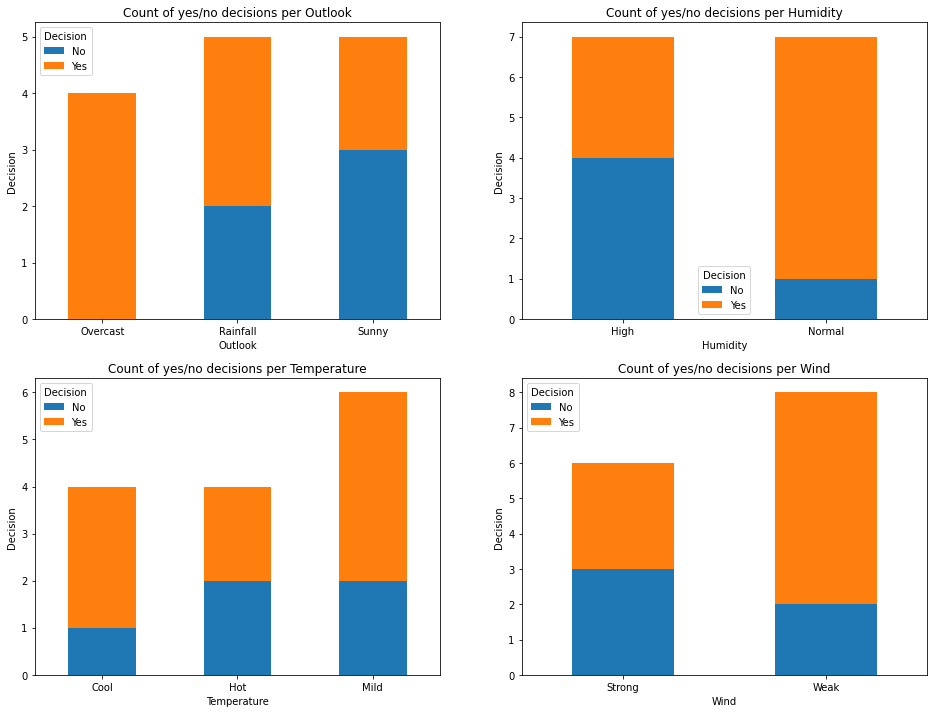

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16,12))
for attribute, loc in zip(weather_data.columns, [(0,0), (1,0),(0,1),(1,1)]):
    if attribute != 'Decision':
        stacked_attribute= weather_data[[attribute,'Decision']].value_counts().to_frame().reset_index().pivot_table(index= attribute, columns= ['Decision'], values= 0)
        stacked_attribute.plot(kind='bar', xlabel= attribute, ylabel='Decision', title= f'Count of yes/no decisions per {attribute}', stacked=True, rot=0, ax = axes[loc[0]][loc[1]])


In above figure, I make the following observations:
 - Decision is always 'yes' when outlook is overcast.
 - Normal humdity associate mostly with 'yes' decision 
 - Decision was equally distrbute between 'yes/no' in case of strong wind.
 
Even after making all this observation, it is tricky when receiving a set of attributes to call for 'yes/no' decision, therefore I will build a decision tree classifier to help me to make this prediction.  

In [8]:
CART =  Classification_And_Regression_Tree(Maximum_purity_per_internal_node = 0.1,
                                           Maximum_tree_depth = 4,
                                           Minimum_number_of_records_per_internal_node = 3,
                                           max_categories = 10)

DecisionTree, avg_accuracy, cv_accuracy = CART.cross_validation(data = weather_data, 
                                                                features_input = ['Temperature', 'Humidity', 'Wind', 'Outlook'],
                                                                labels_column_title = 'Decision',
                                                                cv = 5)
print()
print('Decision Tree for weather dataset is as follows:\n', DecisionTree)
print(f'This tree got an average accuarcy of {avg_accuracy} when running cross validation on 5 folds')
print(f'accuracy this tree has on each fold is: {cv_accuracy}')

Confusion matrix for fold number 1 is as follow:
 actual     No  Yes
predicted         
No          2    0
Yes         0    1

Confusion matrix for fold number 2 is as follow:
 actual     No  Yes
predicted         
No          0    1
Yes         1    1

Confusion matrix for fold number 3 is as follow:
 actual     No  Yes
predicted         
No          0    1
Yes         1    1

Confusion matrix for fold number 4 is as follow:
 actual     Yes
predicted     
No           1
Yes          2

Confusion matrix for fold number 5 is as follow:
 actual     No  Yes
predicted         
No          1    0
Yes         0    1


Decision Tree for weather dataset is as follows:
 Internal_Split_Node(attribute='Outlook', subtrees={'Sunny': Internal_Split_Node(attribute='Humidity', subtrees={'High': Leaf(label='No', Samples=3), 'Normal': Leaf(label='Yes', Samples=2)}, samples=5, label_distribution={'No': 3, 'Yes': 2}, default_value=('No', 3)), 'Overcast': Leaf(label='Yes', Samples=4), 'Rainfall': Internal_

I note that the tree accuracy is fluctuating between each fold during cross validation because of overfitting problem. To reach a better accuracy, a bigger dataset is required (only 14 enteries are available here). 

## Drug Dataset
### Dataset ingestion and Data Wrangling:

[Drugs A, B, C, X, Y for Decision Trees](https://www.kaggle.com/datasets/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees) is imported from kaggle.com. The dataset belongs to lists of patients who received a treatment for the same disease. The differents drugs can be A B C X or Y. The attributes collected for each patients is: 
- Age
- Sex 
- Blood Pressure (refer to as BP)
- Cholesterol level
- Sodium - Potassium (refer to as Na_to_K)
- Drug that worked with that patient


In [9]:
drug_data = pd.read_csv('drug200.csv')
drug_data.head(5)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


The dataset has 200 non-null entries in 6 columns. `Age` and `Na_to_K` columns contain numeric values whereas the other columns have categorical values. 

In [10]:
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


There is not much data cleaning needed to be done beforehand.  On average, patients are 44 years old  and have 16 Sodium - Potassium level.

In [11]:
drug_data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


More observations about the dataset: 
- Almost equal number of male and female patients
- 91 out of 200 patients were cured using `drug y`. 
- Almost equal number of patients has either high or low cholesterol level.

In [12]:
drug_data.describe(include = 'object')

,Sex,BP,Cholesterol,Drug
count,200,200,200,200
unique,2,3,2,5
top,M,HIGH,HIGH,drugY
freq,104,77,103,91


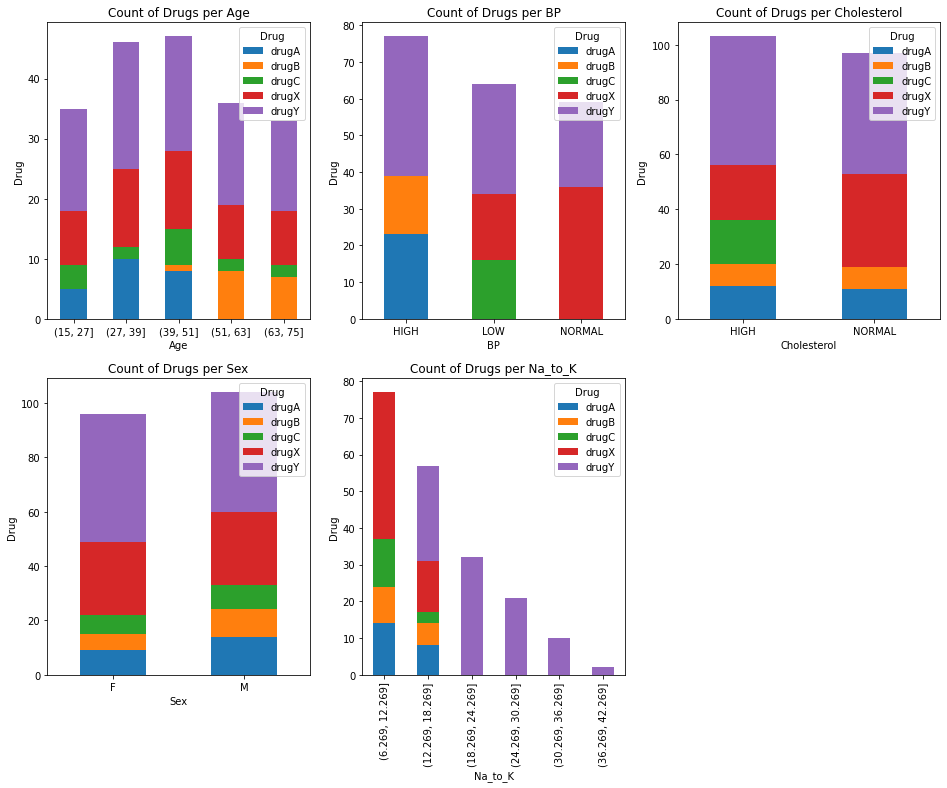

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16,12))
axes[1][2].set_visible(False)
for attribute, loc in zip(drug_data.columns, [(0,0), (1,0), (0,1), (0,2), (1,1)]):
    if drug_data[attribute].dtype == 'O' :
        if attribute != 'Drug':
            stacked_attribute = drug_data[[attribute,'Drug']].value_counts().to_frame().reset_index().pivot_table(index= attribute, columns= ['Drug'],
                                                                                                                 values= 0)
            stacked_attribute.plot(kind='bar', xlabel= attribute, ylabel='Drug', 
                                   title= f'Count of Drugs per {attribute}', stacked=True, 
                                   rot=0, ax = axes[loc[0]][loc[1]])
    else:
        if attribute == 'Age':
            rot = 0
        else:
            rot = 90
        stacked_attribute = drug_data[[attribute,'Drug']].value_counts().to_frame().reset_index().pivot_table(index= attribute, columns= ['Drug'], values= 0)
        step = round((stacked_attribute.index.max()-stacked_attribute.index.min())/5)
        stacked_attribute = stacked_attribute.groupby(pd.cut(stacked_attribute.index, 
                                                             np.arange(stacked_attribute.index.min(),
                                                                       stacked_attribute.index.max() + step,
                                                                       step))).sum()
        stacked_attribute.plot(kind='bar', xlabel= attribute, ylabel='Drug', 
                               title= f'Count of Drugs per {attribute}', 
                               stacked=True, rot = rot, ax = axes[loc[0]][loc[1]])

<AxesSubplot:title={'center':'Count of Drugs per BP when Na_to_K <= 14.5175'}, xlabel='BP', ylabel='Drug'>

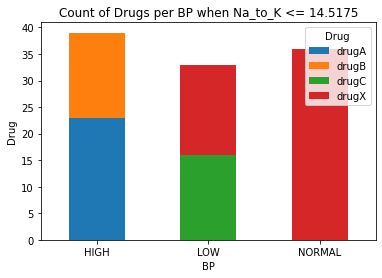

In [14]:
x = drug_data[drug_data['Na_to_K'] <= 14.5175]
stacked_attribute = x[['BP','Drug']].value_counts().to_frame().reset_index().pivot_table(index= 'BP', columns= ['Drug'],
                                                                                                     values= 0)
stacked_attribute.plot(kind='bar', xlabel= 'BP', ylabel='Drug', 
                       title= f'Count of Drugs per BP when Na_to_K <= 14.5175', stacked=True, 
                       rot=0)

I have the following observations:

- `Drug A` has been the cure for patients who are less than 51 years old whereas `drug B` was the cure for patients who are 51 years old and older. 
- Patients with normal blood pressure were cured using either `drug X` or `drug Y`.
- `Drug Y` has been the cure for all patients who have `na_to_k > 18.269`. This makes na_to_k a key variable.

In [15]:
CART =  Classification_And_Regression_Tree(Maximum_purity_per_internal_node = 0.03,
                                           Maximum_tree_depth = 5,
                                           Minimum_number_of_records_per_internal_node = 10,
                                           max_categories = 8)

DecisionTree, avg_accuracy, cv_accuracy = CART.cross_validation(drug_data, 
                                                                ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'],
                                                                'Drug', cv = 5)
print('Decision Tree for drug dataset is as follows:\n', DecisionTree)
print(f'This tree got an average accuarcy of {avg_accuracy} when running cross validation on 5 folds.')
print(f'Accuracy this tree has on each fold is: {cv_accuracy}')

Confusion matrix for fold number 1 is as follow:
 actual     drugA  drugB  drugC  drugX  drugY
predicted                                   
drugA          2      0      0      0      0
drugB          0      1      0      0      0
drugC          0      0      5      0      0
drugX          0      0      0     12      0
drugY          0      0      0      0     20

Confusion matrix for fold number 2 is as follow:
 actual     drugA  drugB  drugC  drugX  drugY
predicted                                   
drugA          5      0      0      0      0
drugB          0      5      0      0      0
drugC          0      0      2      0      0
drugX          0      0      0      9      0
drugY          0      0      0      0     19

Confusion matrix for fold number 3 is as follow:
 actual     drugA  drugB  drugC  drugX  drugY
predicted                                   
drugA          4      0      0      0      0
drugB          1      3      0      0      0
drugC          0      0      3      0 

### Optimization:
I use `cross validation` to select the best maximum tree depth for the model in order to maximize the accuracy metric. 

In [17]:
Maximum_tree_depth = np.arange(0,7,1)

results = {}
cv_scores_std = []
accuracy_scores =[]

for depth in Maximum_tree_depth:
    CART =  Classification_And_Regression_Tree(0.03, depth, 10, 8, False)            
    DecisionTree, avg_accuracy, cv_accuracy = CART.cross_validation(drug_data,
                                                                    ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'],
                                                                     'Drug')
    results[depth] = [DecisionTree, avg_accuracy, cv_accuracy]
    accuracy_scores.append(avg_accuracy)
    cv_scores_std.append(np.array(cv_accuracy).std())
    print(f'Accuracy mean when maximum tree depth = {depth} is {np.array(cv_accuracy).mean()}')

Accuracy mean when maximum tree depth = 0 is 0.45499999999999996
Accuracy mean when maximum tree depth = 1 is 0.72
Accuracy mean when maximum tree depth = 2 is 0.825
Accuracy mean when maximum tree depth = 3 is 0.99
Accuracy mean when maximum tree depth = 4 is 0.99
Accuracy mean when maximum tree depth = 5 is 0.99
Accuracy mean when maximum tree depth = 6 is 0.99


I note that decision tree accuracy is not dependent on these parameters. 

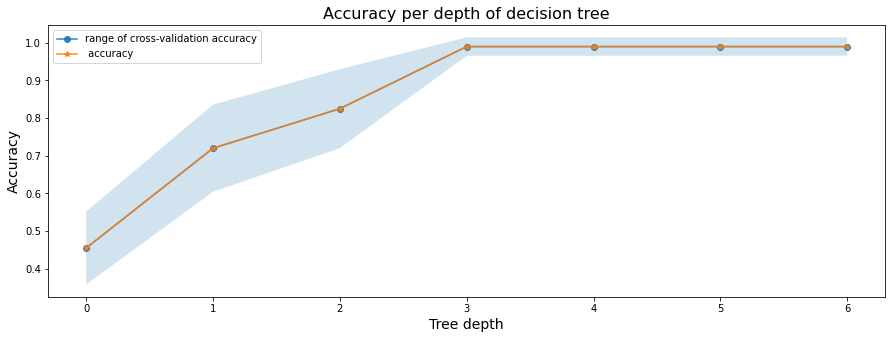

In [19]:
def tree_depth_vs_accuracy(depths, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, accuracy_scores, '-o', label='range of cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, np.array(accuracy_scores)-2*np.array(cv_scores_std), 
                    np.array(accuracy_scores)+2*np.array(cv_scores_std), alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label=' accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

    
tree_depth_vs_accuracy(Maximum_tree_depth, cv_scores_std, accuracy_scores, 
                               'Accuracy per depth of decision tree') 

With tree depth of 0, a leaf node will suggest a drug Y and we get a 0.45 accuracy. The accuracy increases with tree depth and hit a plateau (0.99) when tree depth is 3.